In [1]:
import argparse
import os
import random
import joblib
from typing import Tuple, Dict, Any
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression

In [2]:
# InterpretML
from interpret.glassbox import ExplainableBoostingClassifier, ExplainableBoostingRegressor
# Optuna for Bayesian-style optimization
import optuna

# PyTorch for self-supervised pretraining
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset


c:\Users\Isara Liyanage\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import matplotlib.pyplot as plt
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [4]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [5]:
def demographic_parity_difference(y_true, y_pred_proba, sensitive: np.ndarray, threshold=0.5):
    """Abs difference between positive rates across groups (binary sensitive)."""
    preds = (y_pred_proba >= threshold).astype(int)
    groups = np.unique(sensitive)
    rates = []
    for g in groups:
        mask = (sensitive == g)
        if mask.sum() == 0:
            rates.append(0.0)
        else:
            rates.append(preds[mask].mean())
    return abs(rates[0] - rates[1]) if len(rates) >= 2 else 0.0

In [6]:
def equalized_odds_difference(y_true, y_pred_proba, sensitive: np.ndarray, threshold=0.5):
    """Max absolute difference in TPR and FPR across groups (binary sensitive)."""
    preds = (y_pred_proba >= threshold).astype(int)
    groups = np.unique(sensitive)
    tprs = []
    fprs = []
    for g in groups:
        mask = (sensitive == g)
        if mask.sum() == 0:
            tprs.append(0.0)
            fprs.append(0.0)
            continue
        tp = ((y_true == 1) & (preds == 1) & mask).sum()
        fn = ((y_true == 1) & (preds == 0) & mask).sum()
        fp = ((y_true == 0) & (preds == 1) & mask).sum()
        tn = ((y_true == 0) & (preds == 0) & mask).sum()
        tprs.append(tp / (tp + fn) if (tp + fn) > 0 else 0.0)
        fprs.append(fp / (fp + tn) if (fp + tn) > 0 else 0.0)
    # Differences
    tpr_diff = abs(tprs[0] - tprs[1]) if len(tprs) >= 2 else 0.0
    fpr_diff = abs(fprs[0] - fprs[1]) if len(fprs) >= 2 else 0.0
    return max(tpr_diff, fpr_diff)

In [7]:
def empirical_robustness_noise(model_predict_proba, X, y, noise_std_list=[0.01, 0.05, 0.1]):
    """Simple robustness: drop in ROC AUC under additive Gaussian noise."""
    base_auc = roc_auc_score(y, model_predict_proba(X))
    results = {'base_auc': base_auc}
    for std in noise_std_list:
        Xp = X + np.random.normal(0, std, size=X.shape)
        auc = roc_auc_score(y, model_predict_proba(Xp))
        results[f'auc_noise_{std}'] = auc
    return results


In [8]:
def load_adult_dataset() -> Tuple[pd.DataFrame, pd.Series, np.ndarray]:
    """Load Adult dataset directly from UCI repository."""
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
    df = pd.read_csv(
        url,
        header=None,
        names=[
            "Age", "WorkClass", "fnlwgt", "Education", "EducationNum",
            "MaritalStatus", "Occupation", "Relationship", "Race", "Sex",
            "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"
        ]
    )

    # Label mapping: ">50K" -> 1, "<=50K" -> 0
    df['Income'] = df['Income'].str.strip()
    y = df['Income'].apply(lambda s: 1 if s == '>50K' else 0).astype(int)

    # Features
    X = df.drop(columns=['Income'])

    # Sensitive attribute (as before): "Sex"
    sensitive = (X['Sex'].str.strip() == 'Male').astype(int).values

    return X, y, sensitive

In [9]:
DATASET_LOADERS = {
    'adult': load_adult_dataset,
}


In [10]:
def build_adult_preprocessor(X: pd.DataFrame):
    return FunctionTransformer(lambda x: x)

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit, cross_validate

def format_n(x):
    return "{0:.3f}".format(x)

def train_baseline_ebm(X, y,  params=None, init_score=None, sample_weight=None):
    params = params or {}
    model = ExplainableBoostingClassifier(**params)

    #model.fit(X_train, y_train, sample_weight=sample_weight, init_score=init_score)

    # preds_proba = model.predict_proba(X_val)[:, 1]
    # preds = (preds_proba >= 0.5).astype(int)
    
    ss = StratifiedShuffleSplit(n_splits=3, test_size=0.25, random_state=1337)
    scores = cross_validate(
        model, X, y, scoring='roc_auc', cv=ss,
        n_jobs=None, return_estimator=True
    )

    record = dict()
    record['fit_time_mean'] = format_n(np.mean(scores['fit_time']))
    record['fit_time_std'] = format_n(np.std(scores['fit_time']))
    record['test_score_mean'] = format_n(np.mean(scores['test_score']))
    record['test_score_std'] = format_n(np.std(scores['test_score']))


    # # ---- Print metrics in structured way ----
    # print("\n=== Model Evaluation Results ===")
    # for k, v in metrics.items():
    #     print(f"{k.upper():10}: {v:.4f}")

    # # Confusion Matrix
    # print("\nConfusion Matrix:")
    # cm = confusion_matrix(y_val, preds)
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    # disp.plot(cmap="Blues")
    # plt.title("Confusion Matrix")
    # plt.show()

    # # ---- InterpretML Visualizations ----
    # ebm_global = model.explain_global()
    # show(ebm_global)   # Opens interactive dashboard (works in notebook)

    return model,record

In [12]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, cross_validate
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

def format_n(x):
    return "{0:.5f}".format(x)

def train_baseline_ebm_with_vis(X, y, params=None):
    params = params or {}
    model = ExplainableBoostingClassifier(**params)

    ss = StratifiedShuffleSplit(n_splits=3, test_size=0.25, random_state=1337)
    scores = cross_validate(
        model, X, y, scoring='roc_auc', cv=ss,
        n_jobs=None, return_estimator=True, return_train_score=False
    )

    record = dict()
    record['fit_time_mean'] = format_n(np.mean(scores['fit_time']))
    record['fit_time_std'] = format_n(np.std(scores['fit_time']))
    record['test_score_mean'] = format_n(np.mean(scores['test_score']))
    record['test_score_std'] = format_n(np.std(scores['test_score']))

    # Take the first trained model
    trained_model = scores['estimator'][0]

    # Get one split
    train_idx, test_idx = list(ss.split(X, y))[0]

    # Handle pandas vs numpy gracefully
    if hasattr(X, "iloc"):  # Pandas DataFrame
        X_test = X.iloc[test_idx]
    else:  # NumPy array
        X_test = X[test_idx]

    if hasattr(y, "iloc"):  # Pandas Series
        y_test = y.iloc[test_idx]
    else:  # NumPy array
        y_test = y[test_idx]

    # Confusion matrix
    y_pred = trained_model.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title("Confusion Matrix (Validation Split)")
    plt.show()

    # InterpretML visualization
    ebm_global = trained_model.explain_global()
    show(ebm_global)

    return trained_model, record


In [13]:
class TabularAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=32):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, max(64, latent_dim * 4)),
            nn.ReLU(),
            nn.Linear(max(64, latent_dim * 4), latent_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, max(64, latent_dim * 4)),
            nn.ReLU(),
            nn.Linear(max(64, latent_dim * 4), input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        recon = self.decoder(z)
        return recon, z


In [14]:
def pretrain_autoencoder_get_init_scores(X_unlabeled: np.ndarray, X_small_labeled: np.ndarray, y_small: np.ndarray,
                                         device='cpu', epochs=50, batch_size=256, latent_dim=32):
    """
    Train autoencoder on X_unlabeled (self-supervised), then train a small classifier on
    the encoder output for the labeled subset to produce init_score probabilities.
    Returns init_score for entire dataset (probabilities).
    """
    device = torch.device(device)
    X_unlabeled_t = torch.from_numpy(X_unlabeled.astype(np.float32))
    ds = TensorDataset(X_unlabeled_t)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

    ae = TabularAutoencoder(input_dim=X_unlabeled.shape[1], latent_dim=latent_dim).to(device)
    opt = torch.optim.Adam(ae.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    for ep in range(epochs):
        ae.train()
        epoch_loss = 0.0
        for (batch,) in dl:
            batch = batch.to(device)
            recon, _ = ae(batch)
            loss = loss_fn(recon, batch)
            opt.zero_grad()
            loss.backward()
            opt.step()
            epoch_loss += loss.item() * batch.size(0)
    # build encoder outputs for labeled small set
    ae.eval()
    with torch.no_grad():
        Z_small = ae.encoder(torch.from_numpy(X_small_labeled.astype(np.float32)).to(device)).cpu().numpy()
        Z_full = ae.encoder(torch.from_numpy(X_unlabeled.astype(np.float32)).to(device)).cpu().numpy()

    # train logistic regression on Z_small -> produce probabilities for full set as init_score
    clf = LogisticRegression(max_iter=1000)
    clf.fit(Z_small, y_small)
    init_scores = clf.predict_proba(Z_full)[:, 1]
    return init_scores, ae, clf

In [15]:
output_dir='out_M_Preprocessing'
dataset='adult'

In [16]:
def get_adult_data():
    os.makedirs(output_dir, exist_ok=True)
    print(f'[INFO] Loading {dataset} dataset ...')
    X_df, y, sensitive = DATASET_LOADERS[dataset]()
    preproc = build_adult_preprocessor(X_df)
    X_all = preproc.fit_transform(X_df)
    # convert to numpy arrays for later use
    #X_all = np.asarray(X_all, dtype=float)
    y = np.asarray(y, dtype=int)
    print("[INFO] Loading completed")

   

    return X_all,y

In [80]:
# Baseline EBM
print('[INFO] Training baseline EBM (default params)...')
ebm_params = {"random_state": 1337, "n_jobs": -1}
X_all, y = get_adult_data()
ebm, record = train_baseline_ebm(X_all, y, params=ebm_params)
#print('[BASELINE]', base_metrics)
print('[BASELINE]', record)
# Save baseline model
joblib.dump(ebm, os.path.join(output_dir, 'ebm_baseline.pkl'))


[INFO] Training baseline EBM (default params)...
[INFO] Loading adult dataset ...


[INFO] Loading completed
[BASELINE] {'fit_time_mean': '218.055', 'fit_time_std': '13.579', 'test_score_mean': '0.929', 'test_score_std': '0.002'}


['out_M_Preprocessing\\ebm_baseline.pkl']

[INFO] Training baseline EBM (default params)...
[INFO] Loading adult dataset ...
[INFO] Loading completed


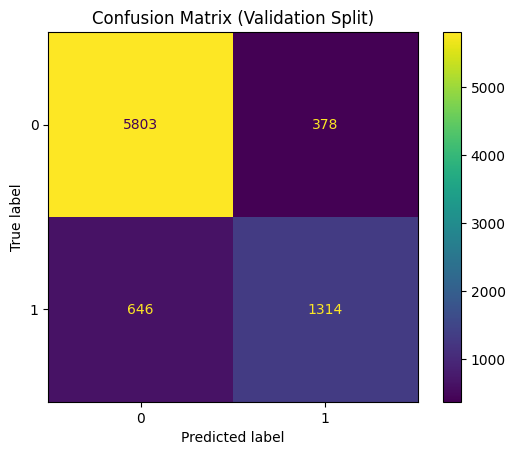

<!-- http://127.0.0.1:7001/1845878205968/ -->

[BASELINE] {'fit_time_mean': '214.52774', 'fit_time_std': '32.02466', 'test_score_mean': '0.92898', 'test_score_std': '0.00181'}


['out_M_Preprocessing\\ebm_baseline.pkl']

In [17]:
# Baseline EBM
print('[INFO] Training baseline EBM (default params)...')
ebm_params = {"random_state": 1337, "n_jobs": -1}
X_all, y = get_adult_data()
ebm, record = train_baseline_ebm_with_vis(X_all, y, params=ebm_params)
#print('[BASELINE]', base_metrics)
print('[BASELINE]', record)
# Save baseline model
joblib.dump(ebm, os.path.join(output_dir, 'ebm_baseline.pkl'))


### Fair Model

[INFO] Training baseline EBM (default params)...
[INFO] Loading adult dataset ...
[INFO] Loading completed


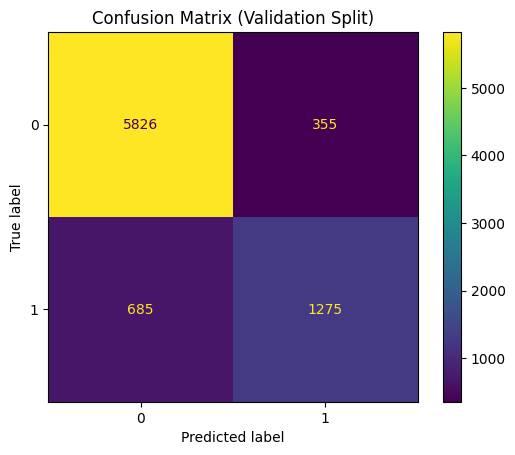

<!-- http://127.0.0.1:7001/1845960097184/ -->

[BASELINE] {'fit_time_mean': '95.98415', 'fit_time_std': '15.11245', 'test_score_mean': '0.92773', 'test_score_std': '0.00179'}


['out_M_Preprocessing\\ebm_baseline_hpo.pkl']

In [18]:
# Baseline EBM
print('[INFO] Training baseline EBM (default params)...')
ebm_params = { 'learning_rate': 0.0067920953019358, 'max_bins': 122, 'max_leaves': 10, 'max_rounds': 350, 'interactions': 9, 'outer_bags': 28, 'inner_bags': 2, 'greedy_ratio': 4.336245909846427, "random_state": 1337,"n_jobs": -1}
X_all, y = get_adult_data()
ebm, record = train_baseline_ebm_with_vis(X_all, y, params=ebm_params)
#print('[BASELINE]', base_metrics)
print('[BASELINE]', record)
# Save baseline model
joblib.dump(ebm, os.path.join(output_dir, 'ebm_baseline_hpo.pkl'))


In [19]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def run_hpo_ebm_without_dp(X_train, y_train, n_trials=40, timeout=None, output_dir='hpo'):
    os.makedirs(output_dir, exist_ok=True)

    def objective(trial):
        # sample hyperparams
        params = {
            'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
            'max_bins': trial.suggest_int('max_bins', 64, 512),
            'max_leaves': trial.suggest_int('max_leaves', 2, 64),
            'max_rounds': trial.suggest_int('max_rounds', 50, 2000),
            'interactions': trial.suggest_int('interactions', 0, 10),
            'outer_bags': trial.suggest_int('outer_bags', 4, 32),
            'inner_bags': trial.suggest_int('inner_bags', 0, 8),
            # greedy ratio can be tuned too
            'greedy_ratio': trial.suggest_float('greedy_ratio', 0.0, 20.0),
        }
      

        model = ExplainableBoostingClassifier(**params)
        #model.fit(X_train, y_train)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
        roc = cross_val_score(model, X_train, y_train, cv=cv, scoring="roc_auc").mean()
      
        objective_value = (1.0 - roc) 

        # store additional info as trial user attributes
        trial.set_user_attr('roc_auc', roc)
       
        trial.set_user_attr('params', params)
        return objective_value

    study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=SEED))
    study.optimize(objective, n_trials=n_trials, timeout=timeout)
    # persist study
    joblib.dump(study, os.path.join(output_dir, 'optuna_study_without_dp.pkl'))
    return study


In [97]:
print('[INFO] Running HPO (Optuna)...')
study = run_hpo_ebm_without_dp(X_all, y, n_trials=15, output_dir=output_dir)
print('[HPO] Best trial:', study.best_trial.params)

[I 2025-09-01 23:45:59,157] A new study created in memory with name: no-name-1d5f642b-f47a-4b77-bf92-0dd541c08718


[INFO] Running HPO (Optuna)...


C:\Users\Isara Liyanage\AppData\Local\Temp\ipykernel_1556\3030925094.py:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-09-01 23:47:31,200] Trial 0 finished with value: 0.07272981207995743 and parameters: {'learning_rate': 0.0013292918943162175, 'max_bins': 490, 'max_leaves': 48, 'max_rounds': 1217, 'interactions': 1, 'outer_bags': 8, 'inner_bags': 0, 'greedy_ratio': 17.323522915498703}. Best is trial 0 with value: 0.07272981207995743.
C:\Users\Isara Liyanage\AppData\Local\Temp\ipykernel_1556\3030925094.py:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-09-01 23:50:09,097] Trial 1 finished with value: 0.07209957243279752 and parameters: {'learning_rate

KeyboardInterrupt: 

### Best Params

[INFO] Training baseline EBM (default params)...
[INFO] Loading adult dataset ...
[INFO] Loading completed


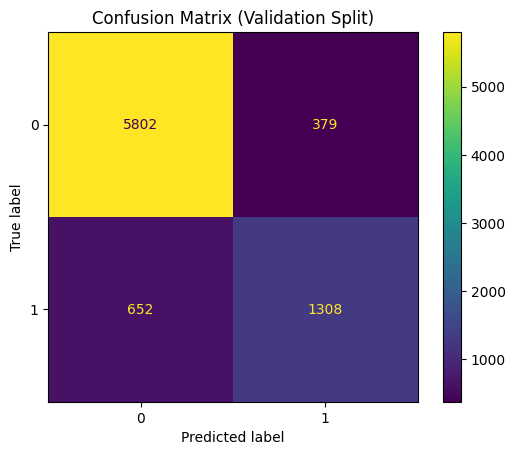

<!-- http://127.0.0.1:7001/1826008770240/ -->

[BASELINE] {'fit_time_mean': '25.56081', 'fit_time_std': '2.78031', 'test_score_mean': '0.92919', 'test_score_std': '0.00168'}


['out_M_Preprocessing\\ebm_baseline_hpo.pkl']

In [23]:
# Baseline EBM
print('[INFO] Training baseline EBM (default params)...')
ebm_params = {'learning_rate': 0.053837171670457214, 'max_bins': 239, 'max_leaves': 8, 'max_rounds': 908, 'interactions': 7, 'outer_bags': 20, 'inner_bags': 0, 'greedy_ratio': 10.890167671001365, "random_state": 1337,"n_jobs": -1}
X_all, y = get_adult_data()
ebm, record = train_baseline_ebm_with_vis(X_all, y, params=ebm_params)
#print('[BASELINE]', base_metrics)
print('[BASELINE]', record)
# Save baseline model
joblib.dump(ebm, os.path.join(output_dir, 'ebm_baseline_hpo.pkl'))


### Pretrain

In [32]:
def preprocessor_with_encoding(X: pd.DataFrame):
    """Auto-detect categorical and numeric columns and build a ColumnTransformer with 
    the same preprocessing steps as benchmark_models."""
    # Detect categorical and numeric columns
    is_cat = np.array([dt.kind == 'O' for dt in X.dtypes])
    cat_cols = X.columns.values[is_cat]
    num_cols = X.columns.values[~is_cat]

    # Pipelines
    cat_pipe = Pipeline([
        ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
    ])
    num_pipe = Pipeline([
        ('identity', FunctionTransformer())
    ])
    ct = ColumnTransformer(
        transformers=[
            ('cat', cat_pipe, cat_cols),
            ('num', num_pipe, num_cols)
        ]
    )
    preproc = Pipeline([
        ('ct', ct),
        ('std', StandardScaler())
    ])

    return preproc


In [33]:
def get_adult_data_with_split():
    os.makedirs(output_dir, exist_ok=True)
    print(f'[INFO] Loading {dataset} dataset ...')
    X_df, y, sensitive = DATASET_LOADERS[dataset]()
    preproc = preprocessor_with_encoding(X_df)
    X_all = preproc.fit_transform(X_df)
    # convert to numpy arrays for later use
    X_all = np.asarray(X_all, dtype=float)
    y = np.asarray(y, dtype=int)
    print("[INFO] Loading completed")

    X_temp, X_test, y_temp, y_test, sens_temp, sens_test = train_test_split(
    X_all, y, sensitive, test_size=0.2, stratify=y, random_state=SEED)
    X_train, X_val, y_train, y_val, sens_train, sens_val = train_test_split(
    X_temp, y_temp, sens_temp, test_size=0.25, stratify=y_temp, random_state=SEED)  # 0.25*0.8 = 0.2

    return X_train, y_train, sens_train, X_val, y_val, sens_val, X_test, y_test, sens_test,X_all

In [34]:
X_train, y_train, sens_train, X_val, y_val, sens_val, X_test, y_test, sens_test, X_all = get_adult_data_with_split()


[INFO] Loading adult dataset ...
[INFO] Loading completed


In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score
import matplotlib.pyplot as plt
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

def format_n(x):
    return "{0:.5f}".format(x)

def train_baseline_ebm_with_vis_init(X, y, params=None, init_score=None):
    """
    Train an ExplainableBoostingClassifier (EBM) with optional init_score.

    Parameters
    ----------
    X : array-like or DataFrame
        Input features.
    y : array-like or Series
        Target labels.
    params : dict, optional
        Extra parameters for the EBM.
    init_score : array-like, optional
        Per-sample initial scores to warm-start EBM.
        Should be aligned with y (same length).
    """
    params = params or {}
    model = ExplainableBoostingClassifier(**params)

    ss = StratifiedShuffleSplit(n_splits=3, test_size=0.25, random_state=1337)

    aucs, fit_times = [], []
    trained_models = []

    for train_idx, test_idx in ss.split(X, y):
        if hasattr(X, "iloc"):  # Pandas
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        else:
            X_train, X_test = X[train_idx], X[test_idx]

        if hasattr(y, "iloc"):
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        else:
            y_train, y_test = y[train_idx], y[test_idx]

        if init_score is not None:
            # Align per-sample scores with current split
            init_score_train = init_score[train_idx]
            model.fit(X_train, y_train, init_score=init_score_train)
        else:
            model.fit(X_train, y_train)

        # Predict probabilities for ROC AUC
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred_proba)
        aucs.append(auc)

        trained_models.append(model)

    # Collect metrics
    record = dict()
    record['test_score_mean'] = format_n(np.mean(aucs))
    record['test_score_std'] = format_n(np.std(aucs) )


    # Use first trained model for visualization
    trained_model = trained_models[0]

    # Pick one split for confusion matrix
    train_idx, test_idx = list(ss.split(X, y))[0]
    if hasattr(X, "iloc"):
        X_test = X.iloc[test_idx]
    else:
        X_test = X[test_idx]
    if hasattr(y, "iloc"):
        y_test = y.iloc[test_idx]
    else:
        y_test = y[test_idx]

    y_pred = trained_model.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title("Confusion Matrix (Validation Split)")
    plt.show()

    # InterpretML visualization
    ebm_global = trained_model.explain_global()
    show(ebm_global)

    return trained_model, record


[INFO] Pretraining autoencoder and deriving init_score...
[INFO] Training EBM initialized from pretrain init_scores...


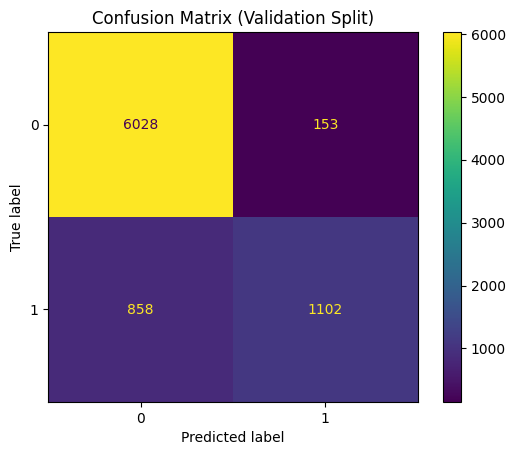

<!-- http://127.0.0.1:7001/1826191583968/ -->

{'test_score_mean': '0.92735', 'test_score_std': '0.00156'}


['out_M_Preprocessing\\ebm_pretrained_init.pkl']

In [39]:
print('[INFO] Pretraining autoencoder and deriving init_score...')
# Use all X_train + X_val + X_test as unlabeled pool for pretraining; use small labeled subset for classifier on latent.
X_unlabeled = X_all  # full data for self-supervision (practical choice)
# small labeled subset (simulate cold-start)
small_idx = np.random.choice(range(len(X_train)), size=int(0.2 * len(X_train)), replace=False)
X_small_labeled = X_train[small_idx]
y_small = y_train[small_idx]
init_scores_full, ae_model, small_clf = pretrain_autoencoder_get_init_scores(
    X_unlabeled, X_small_labeled, y_small, epochs=20, batch_size=256, latent_dim=32)
# Train EBM with init_score (init_score accepts per-sample scores)
# NOTE: InterpretML expects init_score to be either per-sample score array or a model that produces scores.
print('[INFO] Training EBM initialized from pretrain init_scores...')
trained_model, record= train_baseline_ebm_with_vis_init(X_all, y, init_score=init_scores_full)
print(record)
joblib.dump(trained_model, os.path.join(output_dir, 'ebm_pretrained_init.pkl'))

### Pretraining with HPO

[INFO] Pretraining autoencoder and deriving init_score...
[INFO] Training EBM initialized from pretrain init_scores...


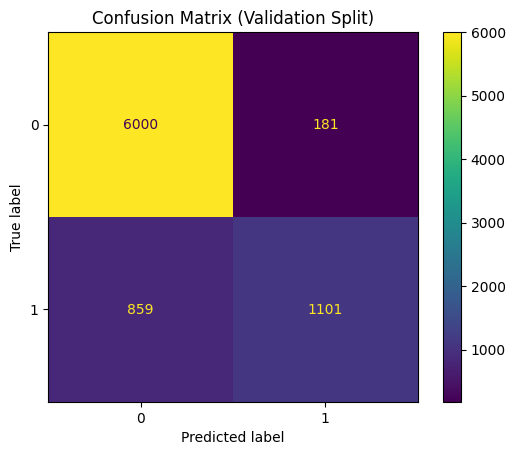

<!-- http://127.0.0.1:7001/1826191184896/ -->

{'test_score_mean': '0.92997', 'test_score_std': '0.00161'}


['out_M_Preprocessing\\ebm_pretrained_init.pkl']

In [53]:
print('[INFO] Pretraining autoencoder and deriving init_score...')
# Use all X_train + X_val + X_test as unlabeled pool for pretraining; use small labeled subset for classifier on latent.
X_unlabeled = X_all  # full data for self-supervision (practical choice)
# small labeled subset (simulate cold-start)
small_idx = np.random.choice(range(len(X_train)), size=int(0.2 * len(X_train)), replace=False)
X_small_labeled = X_train[small_idx]
y_small = y_train[small_idx]
init_scores_full, ae_model, small_clf = pretrain_autoencoder_get_init_scores(
    X_unlabeled, X_small_labeled, y_small, epochs=20, batch_size=256, latent_dim=32)
# Train EBM with init_score (init_score accepts per-sample scores)
# NOTE: InterpretML expects init_score to be either per-sample score array or a model that produces scores.

ebm_params = {'learning_rate': 0.053837171670457214, 'max_bins': 239, 'max_leaves': 8, 'max_rounds': 908, 'interactions': 7, 'outer_bags': 20, 'inner_bags': 0, 'greedy_ratio': 10.890167671001365, "random_state": 1337,"n_jobs": -1}


print('[INFO] Training EBM initialized from pretrain init_scores...')
trained_model, record= train_baseline_ebm_with_vis_init(X_all, y, init_score=init_scores_full,params=ebm_params)
print(record)
joblib.dump(trained_model, os.path.join(output_dir, 'ebm_pretrained_init.pkl'))